# Cluster analysis

 by Thibaut Perol

In [29]:
%matplotlib inline
import numpy as np
import scipy as sp
import json
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from pyquery import PyQuery as pq
import requests
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import random

In [30]:
#initialize the dataframe with 1980 data
since_1980_df = pd.DataFrame()
since_1980_df = pd.read_csv('http://wichita.ogs.ou.edu/eq/catalog/1980/1980.csv')

# add additional years
for year in range(1981,2016):
    url = 'http://wichita.ogs.ou.edu/eq/catalog/' + str(year) + '/' + str(year) + '.csv'
    temp_df = pd.read_csv(url)
    # This might not be the most efficient method
    since_1980_df = since_1980_df.append(temp_df)
since_1980_df.head()

,id,origintime,latitude,longitude,depth,err_lon,err_lat,err_depth,err_origintime,county,origin_src,prefmag,pmag_type,pmag_src,mw,mw_src,mblg_ogs,mblg_usgs,ml_ogs,m3hz_ogs,md_ogs,mb,ms,mfa,max_mmi,reafile,reamtime,geom,pdlid,mw_ogs
0,255,1980-01-05 07:11:31.21,35.586,-97.894,5,NaN,NaN,NaN,NaN,CANADIAN,OGS,1.9,M3Hz,OGS,NaN,NaN,1.6,NaN,NaN,1.9,1.7,NaN,NaN,NaN,NaN,NaN,NaN,0101000020E6100000F0A7C64B377958C05EBA490C02CB...,NaN,NaN
1,256,1980-01-12 07:12:56.45,36.453,-97.642,5,NaN,NaN,NaN,NaN,GARFIELD,OGS,1.7,M3Hz,OGS,NaN,NaN,NaN,NaN,NaN,1.7,1.4,NaN,NaN,NaN,NaN,NaN,NaN,0101000020E61000000C022B87166958C0448B6CE7FB39...,NaN,NaN
2,257,1980-02-03 00:46:30.05,33.994,-97.463,5,NaN,NaN,NaN,NaN,LOVE,OGS,2.2,M3Hz,OGS,NaN,NaN,1.9,NaN,NaN,2.2,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0101000020E61000001283C0CAA15D58C0AC1C5A643BFF...,NaN,NaN
3,258,1980-02-05 04:32:35.45,34.046,-97.451,5,NaN,NaN,NaN,NaN,LOVE,OGS,2.1,M3Hz,OGS,NaN,NaN,2.3,NaN,NaN,2.1,1.9,NaN,NaN,NaN,3,NaN,NaN,0101000020E6100000BE9F1A2FDD5C58C0D9CEF753E305...,NaN,NaN
4,259,1980-03-09 03:57:10.56,35.100,-95.100,5,NaN,NaN,NaN,NaN,HASKELL,OGS,1.2,M3Hz,OGS,NaN,NaN,1.4,NaN,NaN,1.2,1.4,NaN,NaN,NaN,NaN,NaN,NaN,0101000020E61000006666666666C657C0CDCCCCCCCC8C...,NaN,NaN


In [31]:
# Extract year of earthquake events
import time
year_day = []
year = []
for date in since_1980_df.origintime.values:
    new_date = time.strptime(date[:19], "%Y-%m-%d %H:%M:%S")
    year_day.append(new_date.tm_yday)
    year.append(new_date.tm_year)
# Add to data frame the day of a year of earthquake
since_1980_df['year_day'] = year_day
# Add to data frame the year of earthquake
since_1980_df['year'] = year

In [32]:
since_1980_df.shape

(18895, 32)

# Testing the DBSCAN algorithm


Here I am testing the DBSCAN clustering algorithm.


In [ ]:
# run this cell to choose a subset of the data

# define subset of data
# choose randomly half of the values
sample_size = since_1980_df.shape[0]
subset = since_1980_df.iloc[random.sample(since_1980_df.index,sample_size)]

## Choose the features

Now we want to apply the DBSCAN algorithm to our data. The features would be longitude, lattitude and depth.

In [131]:
# import libraries for DBSCAN
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

##############################################################################
# Compute DBSCAN
##############################################################################


centers = [[1, 1], [-1, -1], [1, -1]]
X_t = []

for (lat,longi,z) in zip(subset.latitude,subset.longitude,subset.depth):
    X_t.append([lat,longi,z])
np.array(X_t)
db = DBSCAN(min_samples=100).fit(X_t)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
# note that noise is when the label is -1
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)          

Estimated number of clusters: 3


## Plot

Plot the clusters on a map with longitude and latitude.

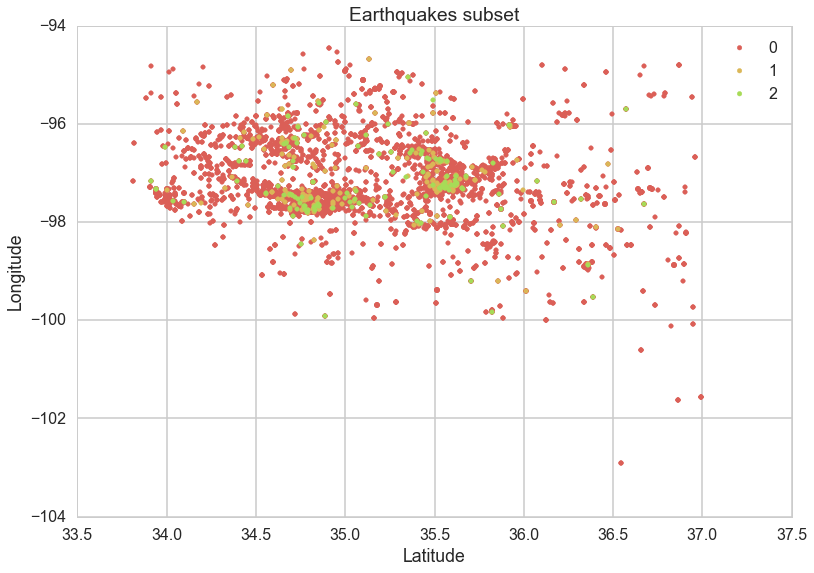

In [139]:
# get the set of labels
various_labels = set(labels)
sns.set_palette('husl')
for i in range(0,len(list(various_labels))):
    if list(various_labels)[i]!=-1:
        mask = db.labels_ == list(various_labels)[i]
        plt.scatter(subset.latitude[mask], subset.longitude[mask],label=list(various_labels)[i], color = sns.color_palette('hls',9)[i], alpha =1);
plt.xlabel('Latitude');
plt.ylabel('Longitude');
plt.title("Earthquakes subset");
plt.legend();